In [4]:
import os 
import numpy as np 
import pandas as pd 
import cv2
from glob import glob  

import tensorflow as tf
import albumentations as A
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.utils import Sequence 
# import tensorflow_addons as tfa

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))



2.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Creation and Augmentation

In [5]:
def albu_transform_train():
    return A.Compose([
                    A.RandomRotate90(p=0.1),
                    A.OneOf([
                        A.HorizontalFlip(p=0.5), 
                        A.VerticalFlip(p=0.5)],p=0.5)
                      ],p=1)

def albu_transform_valid():
    return A.Compose([A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.1)])

In [27]:
class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size=1, image_size=512, shuffle=True, transform=None):
        """Initialization
        :param image_files: list of all images ids (file names)
        :param mask_files: list of mask labels (file names)
        :param batch_size: create batch of images
        :param image_size: path to masks location
        :param shuffle: True to shuffle label indexes after every epoch
        :param augment: To set augmentation Flag True/False
        """
        self.image_filenames = image_files
        self.mask_names = mask_files
        self.batch_size = batch_size
        self.image_shape = (image_size, image_size)
        self.list_IDs = np.arange(len(self.image_filenames))
        self.shuffle = shuffle
        self.augmentation = transform
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle: 
            np.random.shuffle(self.indexes)

    def read_image_mask(self, image_name, mask_name):
        input_img = tf.keras.utils.load_img(image_name,target_size=(self.image_shape[0],self.image_shape[1]))
        input_img = tf.keras.utils.img_to_array(input_img,dtype=np.float32)
        
        mask_img = tf.keras.utils.load_img(mask_name,grayscale=True,target_size=(self.image_shape[0],self.image_shape[1]))
        mask_img = tf.keras.utils.img_to_array(mask_img,dtype=np.float32)
        # mask_img = self.decode_segmentation_masks_gray(mask_img)
        return input_img/255.0, mask_img
    
    def transform_data(self,image,mask):
        transformed = self.augmentation(image=image, mask=mask)
        transform_image = transformed['image']
        transform_mask = transformed['mask']
        return transform_image,transform_mask

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Defining dataset
        X = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], 3),dtype=np.float32)
        Y = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], 1),dtype=np.float32)
        
        for i, index in enumerate(list_IDs_temp):
            X_sample, Y_sample = self.read_image_mask(self.image_filenames[index],self.mask_names[index])
            # X_sample, Y_sample = self.read_image_mask(self.image_filenames[index],self.mask_names[index])
            if self.augmentation is not None:
                X_sample, Y_sample = self.transform_data(X_sample,Y_sample)
            if self.batch_size == 1:
                X = np.reshape(X_sample,(1,X_sample.shape[0], X_sample.shape[1],3))
                Y = np.reshape(Y_sample,(1,Y_sample.shape[0], Y_sample.shape[1],1))
                return X,Y
            else:        
                X[i, ...] = X_sample
                Y[i, ...] = Y_sample
        return X, Y
    
    @staticmethod
    def decode_segmentation_masks_gray(mask):
        gray = np.zeros_like(mask).astype(np.uint8)
        idx = mask > 0.5  # since sigmoid function is used in binary model
        gray[idx] = 255
        return gray

In [28]:
mount_path = "data/temp" 
images = glob(os.path.join(mount_path,'*/images/*.tiff'))
masks = glob(os.path.join(mount_path,"*/masks/*.png"))

print("Total Images :",len(images))
print("Total Masks :",len(images))


train, valid = train_test_split(images,train_size = 0.80,test_size=0.2, random_state=1)

print("Training Data:",len(train))
print("Validation Data:",len(valid))

Total Images : 2640
Total Masks : 2640
Training Data: 2112
Validation Data: 528


In [29]:
BATCH_SIZE = 8
IMG_SIZE = 512

train_masks = [image_name.replace('images','masks').replace('tiff','png') for image_name in train]
valid_masks = [imgname.replace('images','masks').replace('tiff','png') for imgname in valid]

In [30]:
# setting generators
train_generator = DataGenerator(image_files= train, 
                            mask_files = train_masks, 
                            batch_size=BATCH_SIZE,
                            transform=albu_transform_train(),image_size=IMG_SIZE
                            )

test_generator = DataGenerator(image_files= valid,mask_files=valid_masks,batch_size=1)



/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


input size (8, 512, 512, 3) (8, 512, 512, 1)


In [ ]:
Xtrain, ytrain = train_generator.__getitem__(3)
print("input size",Xtrain.shape,ytrain.shape)

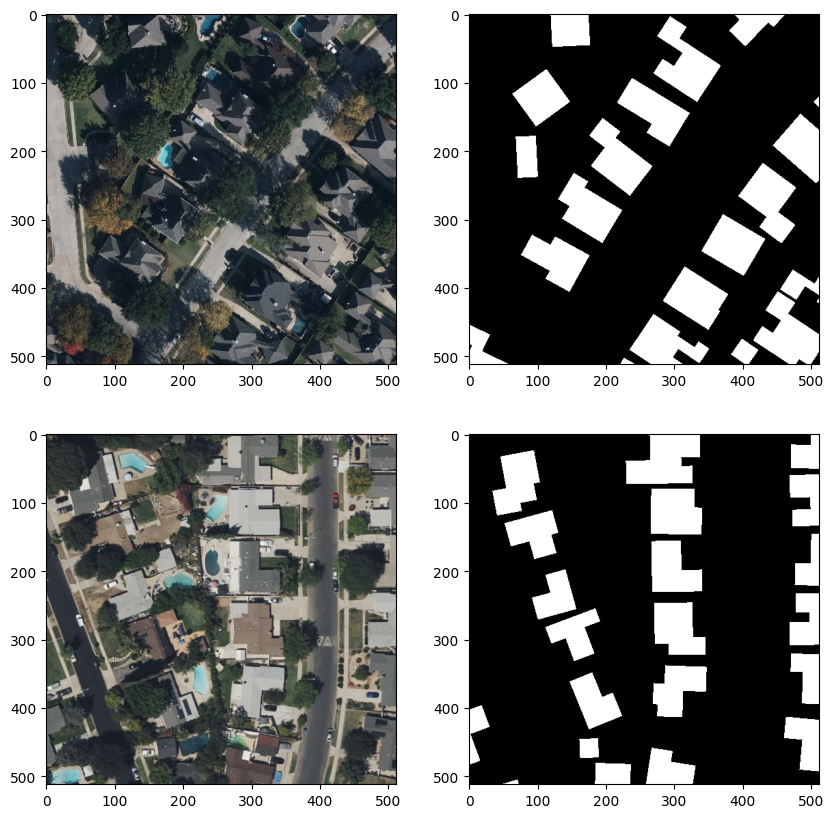

In [33]:
plt.figure(figsize=(10,10))
count = 0
for i in range(4):
    Xtest, ytest = test_generator.__getitem__(i*np.random.randint(0,10))
    #output_img = ytest[0, :,:,0]
    
    if count>=4:break 
    count +=1
    plt.subplot(2,2,count)
    plt.imshow(Xtest[0])
    count +=1
    plt.subplot(2,2,count)
    plt.imshow(ytest[0],cmap='gray')